# Investment Simulation
The goal of this notebook is to estimate finances in retirement based on inputs
such as contribution percentages to various account types, investment growth,
required minimum distributions, etc.

The inputs are listed first, and projections are performed at the end. Review each
section and update as needed as.

## People
This section captures information about the people being studied

In [1]:
from life_model.family import Family
from life_model.person import Person, Spending

family = Family()

john = Person(
    family = family,
    name = 'John',
    age = 44,
    retirement_age = 60,
    spending = Spending(
        base = 12000,
        yearly_increase = 5
    )
)

jane = Person(
    family = family,
    name = 'Jane',
    age = 45,
    retirement_age = 60,
    spending = Spending(
        base = 12000,
        yearly_increase = 5
    )
)

family

## Bank Accounts
Bank accounts associated with each person. These earn a small amount of interest, which may be compounded at different rates, however the rates are much lower than other types of accounts.

In [2]:
from life_model.account.bank import BankAccount

BankAccount(
    owner = john,
    company = 'Bank of America',
    type = 'Checking',
    balance = 20000,
    interest_rate = 0.5
)
BankAccount(
    owner = jane,
    company = 'Credit Union',
    type = 'Checking',
    balance = 20100,
    interest_rate = 0.01
)
BankAccount(
    owner = jane,
    company = 'Credit Union',
    type = 'Savings',
    balance = 20100,
    interest_rate = 0.01
)

family

## Jobs
This section captures information about people's jobs

In [3]:
from life_model.job import Job, Salary

wendys = Job(
    owner = john,
    company = 'Wendys',
    role = 'Manager',
    salary = Salary(
        base = 50000,
        yearly_increase = 1,
        yearly_bonus = 1
    )
)

pizza_hut = Job(
    owner = jane,
    company = 'Pizza Hut',
    role = 'Manager',
    salary = Salary(
        base = 65000,
        yearly_increase = 1,
        yearly_bonus = 1
    )
)

family

## 401k Accounts
Retirement accounts set up by a company, usually offering some sort of match

In [4]:
from life_model.account.job401k import Job401kAccount

Job401kAccount(
    job = wendys,
    pretax_balance = 100000,
    pretax_contrib_percent = 15,
    roth_balance = 100000,
    roth_contrib_percent = 5,
    average_growth = 5,
    company_match_percent = 50
)

Job401kAccount(
    job = pizza_hut,
    pretax_balance = 50000,
    pretax_contrib_percent = 15,
    roth_balance = 50000,
    roth_contrib_percent = 5,
    average_growth = 5,
    company_match_percent = 0
)


## Life Events
Expected life events happening at a certain time

In [5]:
from life_model.person import LifeEvent

john.life_events = [
    LifeEvent(50, john.get_married, jane)
]

## Simulation
Shows the result of retirement


In [6]:
from datetime import date
import pandas as pd

time_data = []
start_year = date.today().year
years = range(start_year, start_year + 50)
for year in years:
    family.year = year
    family.advance_year()
    year_end_data = family.get_stats()
    year_end_data['year'] = year
    time_data.append(year_end_data)

family.event_log

Year:,Event:
2027,John and Jane got married at age 50 and 50
2035,Jane reached retirement age (age 59.5)
2036,Jane retired from Pizza Hut
2036,John reached retirement age (age 59.5)
2037,John retired from Wendys


In [7]:
df= pd.DataFrame({
    'Date': years,
    'Income': [x['stat_gross_income'] for x in time_data],
    'Balance': [x['stat_useable_balance'] for x in time_data],
    'Taxes': [x['stat_taxes_paid'] for x in time_data],
    'Spending': [x['stat_money_spent'] for x in time_data]})
df.style.format(precision=0, na_rep='MISSING',
                formatter={'Income': '${:,.0f}',
                           'Balance': '${:,.0f}',
                           'Taxes': '${:,.0f}',
                           'Spending': '${:,.0f}'}).hide_index()

Date,Income,Balance,Taxes,Spending
2022,"$117,312","$154,596","$14,641","$25,200"
2023,"$118,485","$210,214","$14,912","$26,460"
2024,"$119,669","$265,371","$15,187","$27,783"
2025,"$120,866","$320,009","$15,464","$29,172"
2026,"$122,075","$374,067","$15,745","$30,631"
2027,"$123,296","$427,481","$16,796","$32,162"
2028,"$124,529","$479,445","$17,027","$33,770"
2029,"$125,774","$530,711","$17,261","$35,459"
2030,"$127,032","$581,204","$17,496","$37,232"
2031,"$128,302","$630,848","$17,734","$39,093"


In [8]:
df_total = pd.DataFrame({
    'Dates': ['Total'],
    'Income': [sum(x['stat_gross_income'] for x in time_data)],
    'Balance': [sum(x['stat_useable_balance'] for x in time_data)],
    'Taxes': [sum(x['stat_taxes_paid'] for x in time_data)],
    'Spending': [sum(x['stat_money_spent'] for x in time_data)]})
df_total.style.format(precision=0, na_rep='MISSING',
                formatter={'Income': '${:,.0f}',
                           'Balance': '${:,.0f}',
                           'Taxes': '${:,.0f}',
                           'Spending': '${:,.0f}'}).hide_index()

Dates,Income,Balance,Taxes,Spending
Total,"$1,812,133","$79,245,964","$358,413","$5,275,569"


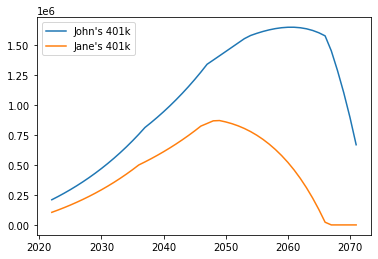

In [9]:
import matplotlib.pyplot as plt

year_df = pd.DataFrame(index = [x['year'] for x in time_data])
year_df["John's 401k"] = john.legacy_retirement_accounts[0].stat_balance_history
year_df["Jane's 401k"] = jane.legacy_retirement_accounts[0].stat_balance_history

year_df.plot(subplots=False, legend=True)
plt.legend(loc='best')
plt.show()